The objective of this notebook is to generate synthetic data which has the same variability as the historical data. In particular, we want the synthetic data to have the same covariance matrix as the historical data.
## Which variables should be included in this covariance matrix?
Some of the variables do not look Normal, and therefore the multivariate_normal method will always fail to make data that resembles the original distributions. Based on the histograms, Treasury Rate, home price index, mortgage rate, rent index, and vacancy rate seem more like uniform distributions (though home price index looks potentially like a bimodal Normal). I would exclude these variables from this data generation process. In the last cell, I generated new data without these variables included in the covariance matrix. The plots didn't change much, but at least it's easier to focus on the variables where you have a chance at modelling them as Normal.
### End goal -> Input needed
The output of this data generation should be return rates that can be multiplied by a portfolio value to give a return. Due to the time-dependency of some of the indexes, indexes are not always as valuable a output as the derivative of the indexes. We need the values that are going to show the most accurate/useful co-variances.
| Value | Index | Derivative | Which to use |
| :- | -: | :-: | :-: |
| Equity | S&P 500 Index | Return rate | Derivative
| Inflation | CPI | Inflation rate | CPI
| Bonds | Treasury 10-Year Yield | Rate of change | Index
| RE Appreciation | Home Price Index | Appreciation | Derivative
| RE Borrowing Cost | 30-Year Fixed Rate Mortgage | Rate of change | Index
| RE Income | Rent Index | Rate of change | Derivative
| RE Vacancy | Rental Vacancy Rate | Rate of change | Index


In [12]:
import numpy as np,pandas as pd
import matplotlib.pyplot as plt, seaborn as sn

In [24]:
SP500_quart_rate = pd.read_csv('SP500_quart_rate.csv',header=0,names=['DATE','SP500_Return'])
inflation_quart_rate = pd.read_csv('inflation_quart_rate.csv',header=0,names=['DATE','CPI','Inflation_Rate'])
treasury_bond_quart_rate = pd.read_csv('treasury_bond_quart_rate.csv',header=0,names=['DATE','Treasury_Yield','Treasury_Yield_Change'])
home_price_quart_rate = pd.read_csv('home_price_quart_rate.csv',header=0,names=['DATE','Home_Price_Index','Home_Price_Appreciation'])
mortgage_quart_rate = pd.read_csv('mortgage_quart_rate.csv',header=0,names=['DATE','Mortgage_Rate','Mortgage_Rate_Change'])
rent_quart_rate = pd.read_csv('rent_quart_rate.csv',header=0,names=['DATE','Rent_Index','Rent_Change'])
vacancy_quart_rate = pd.read_csv('vacancy_quart_rate.csv',header=0,names=['DATE','Vacancy_Rate','Vacancy_Rate_Change'])

merged_df = SP500_quart_rate.merge(inflation_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(treasury_bond_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(home_price_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(mortgage_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(rent_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(vacancy_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df.drop(columns=['Treasury_Yield_Change','CPI','Home_Price_Index','Mortgage_Rate_Change','Rent_Index','Vacancy_Rate_Change'],inplace=True)
merged_df.describe()

,SP500_Return,Inflation_Rate,Treasury_Yield,Home_Price_Appreciation,Mortgage_Rate,Rent_Change,Vacancy_Rate
count,605.000000,301.000000,241.000000,189.000000,204.000000,301.000000,265.000000
mean,0.025429,0.008704,0.059338,0.012510,0.077726,0.008940,0.073060
std,0.080675,0.008152,0.029919,0.014110,0.032947,0.005044,0.015031
min,-0.269888,-0.022902,0.006506,-0.031516,0.027607,-0.000420,0.050000
25%,-0.015856,0.003890,0.038921,0.007493,0.050481,0.005618,0.059000
50%,0.026396,0.007634,0.057461,0.012348,0.074385,0.008236,0.073000
75%,0.071714,0.011460,0.076738,0.017778,0.095698,0.011752,0.082000
max,0.646952,0.040632,0.148384,0.067942,0.177357,0.034749,0.111000


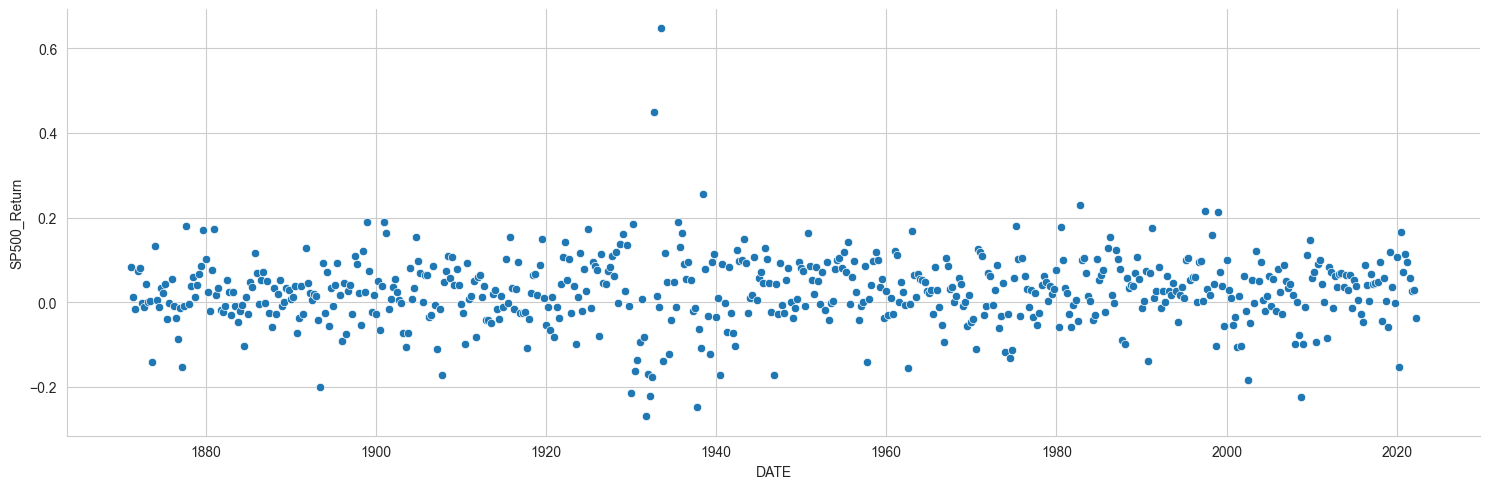

In [25]:
merged_df['DATE']= pd.to_datetime(merged_df['DATE'])
sn.set_style('whitegrid')
sn.relplot(data=merged_df, x='DATE', y='SP500_Return',
           aspect=3
          )
plt.show()

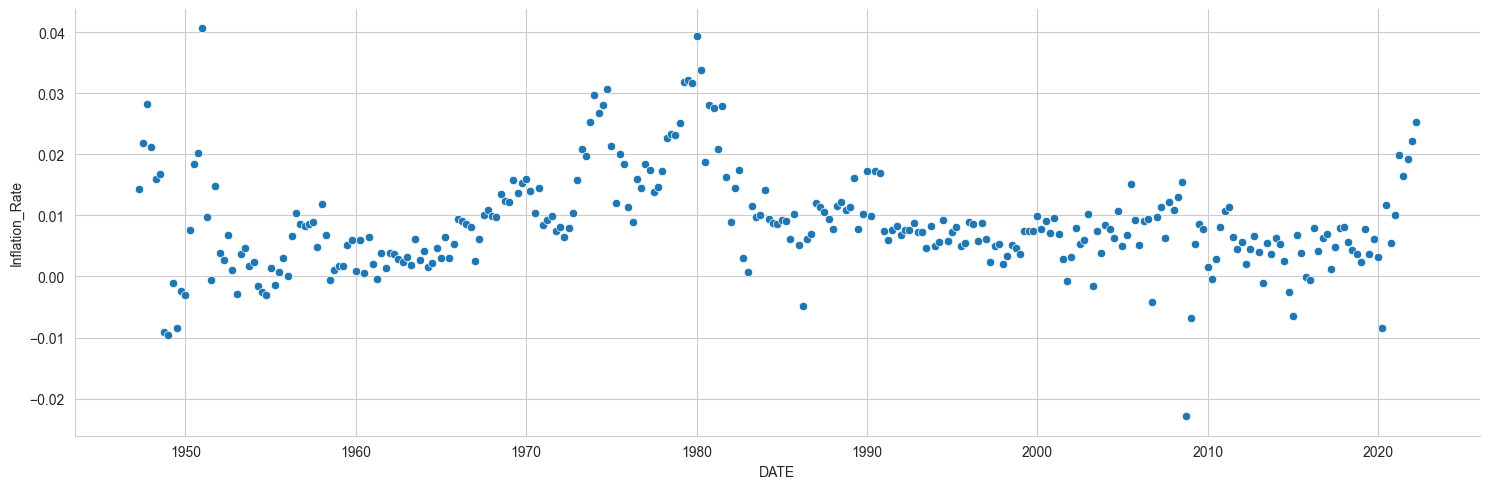

In [26]:
sn.relplot(data=merged_df, x='DATE', y='Inflation_Rate',
           aspect=3)
plt.show()

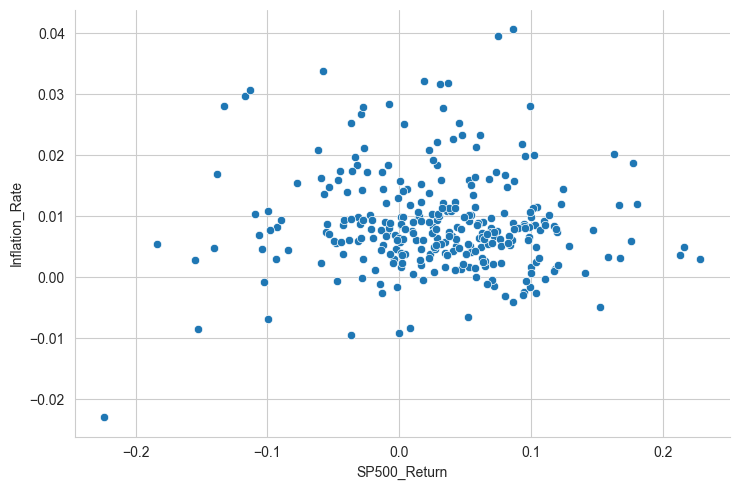

In [27]:
sn.relplot(data=merged_df, x='SP500_Return',
            y='Inflation_Rate', aspect=1.5
           )
plt.show()

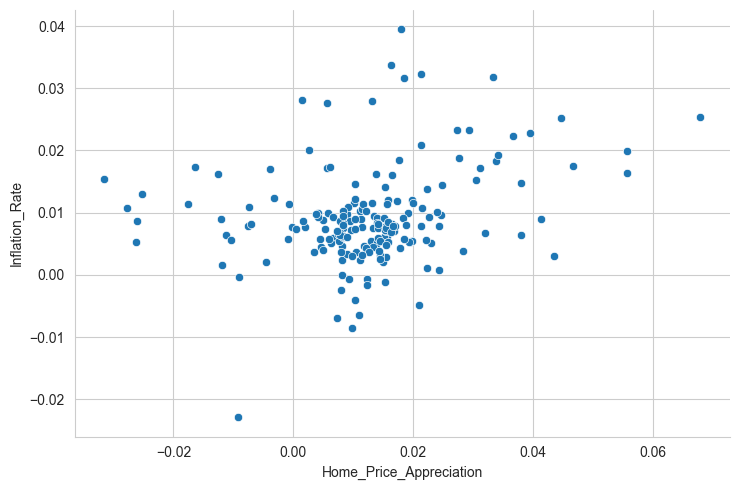

In [28]:
sn.relplot(data=merged_df, x='Home_Price_Appreciation',
            y='Inflation_Rate', aspect=1.5
           )
plt.show()

                         SP500_Return  Inflation_Rate  Treasury_Yield  \
SP500_Return                 0.006508       -0.000024        0.000019   
Inflation_Rate              -0.000024        0.000066        0.000116   
Treasury_Yield               0.000019        0.000116        0.000895   
Home_Price_Appreciation      0.000097        0.000030        0.000012   
Mortgage_Rate               -0.000015        0.000125        0.001043   
Rent_Change                 -0.000027        0.000022        0.000088   
Vacancy_Rate                -0.000005       -0.000057       -0.000234   

                         Home_Price_Appreciation  Mortgage_Rate  Rent_Change  \
SP500_Return                            0.000097      -0.000015    -0.000027   
Inflation_Rate                          0.000030       0.000125     0.000022   
Treasury_Yield                          0.000012       0.001043     0.000088   
Home_Price_Appreciation                 0.000199       0.000007     0.000019   
Mortgage_Rate  

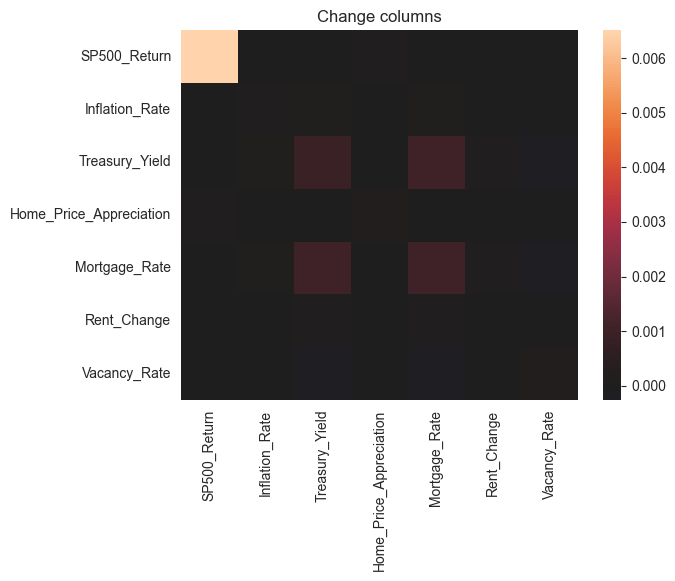

In [29]:
covMatrix = merged_df.cov()
print(covMatrix)
# sn.heatmap(covMatrix, vmin=-1, vmax=1, center=0)
sn.heatmap(covMatrix, center=0)
plt.title('Change columns')
plt.show()

In [30]:
covMatrix = merged_df.drop(columns='DATE').cov().values
mu = merged_df.drop(columns='DATE').mean().values
print("Shape of covariance matrix",covMatrix.shape)
print("Shape of averages", mu.shape)

Shape of covariance matrix (7, 7)
Shape of averages (7,)


In [31]:
num_samples = 300
rng = np.random.default_rng()
gen_data = rng.multivariate_normal(mu, covMatrix, size=num_samples)

C:\Users\kellychris\AppData\Local\Temp\ipykernel_22560\2918175329.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  gen_data = rng.multivariate_normal(mu, covMatrix, size=num_samples)


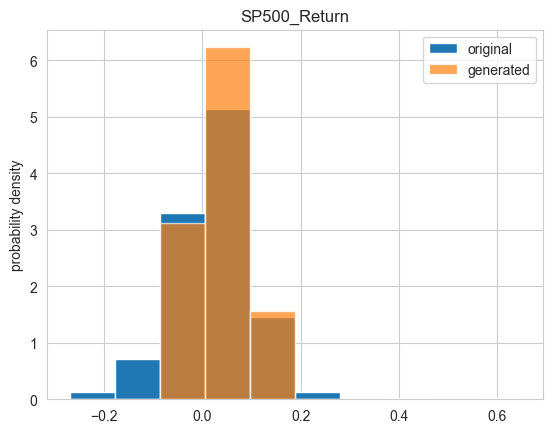

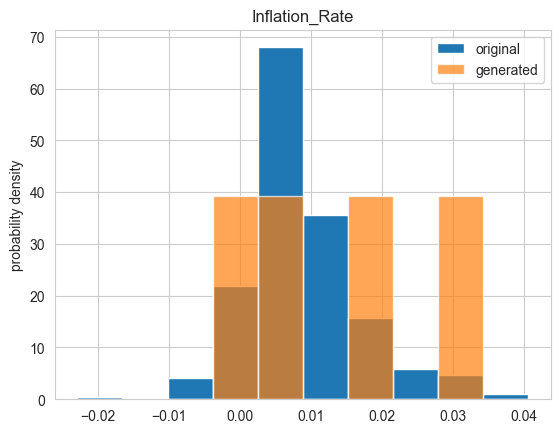

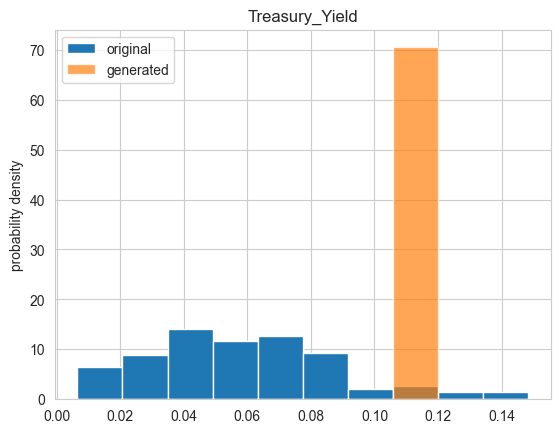

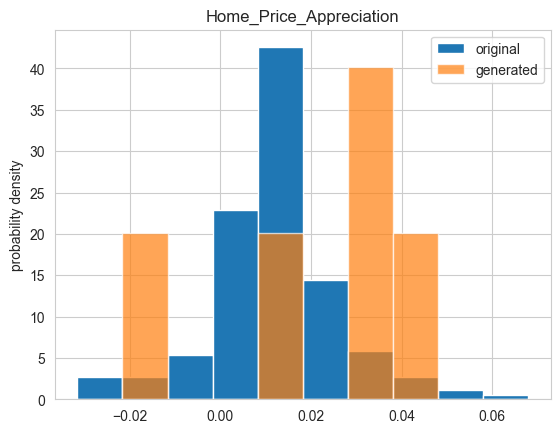

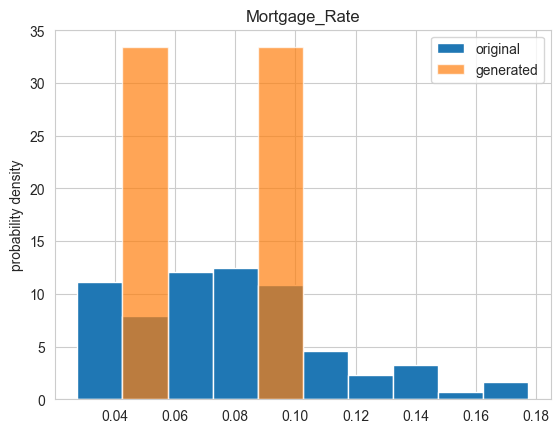

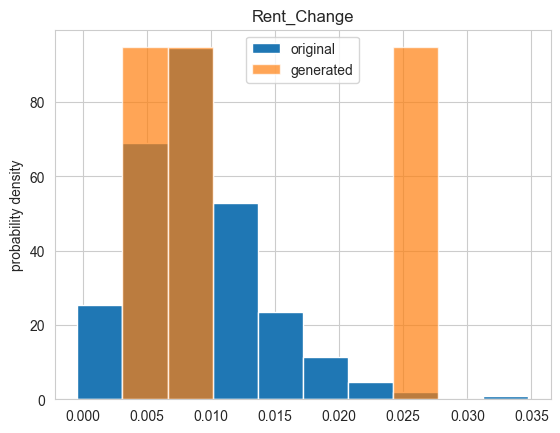

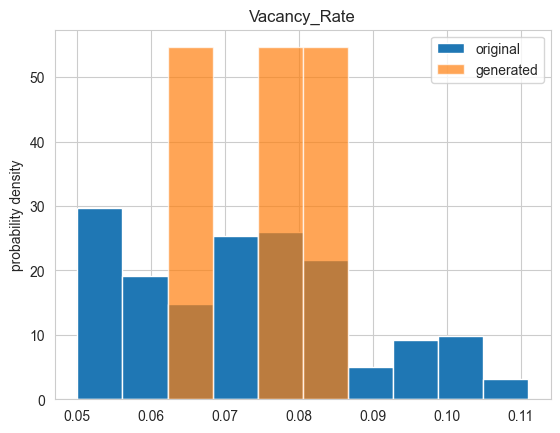

In [32]:
for idx, col in enumerate(merged_df.drop(columns='DATE').columns):
    plt.figure()
    plt.title(col)
    #use the same bins for both plots and normalize the density
    _, bins, _= plt.hist(merged_df[col],label='original', density=True)
    plt.hist(gen_data[idx],label='generated', bins=bins, density=True, alpha=0.7)
    plt.ylabel('probability density')
    plt.legend()

In [33]:
col2drop=['DATE', 'Treasury_Yield','Home_Price_Index',
          'Mortgage_Rate','Rent_Index', 'Vacancy_Rate'
         ]
covMatrix = merged_df.drop(columns=col2drop).cov().values
mu = merged_df.drop(columns=col2drop).mean().values
gen_data = rng.multivariate_normal(mu, covMatrix, size=num_samples)

KeyError: "['Home_Price_Index', 'Rent_Index'] not found in axis"

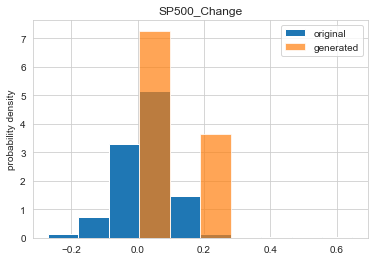

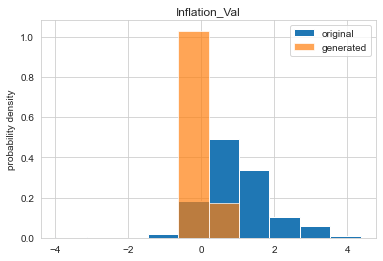

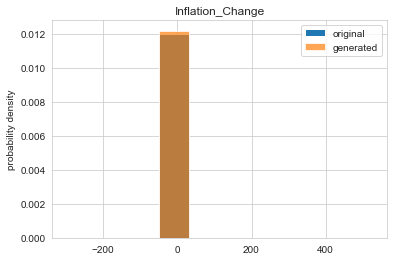

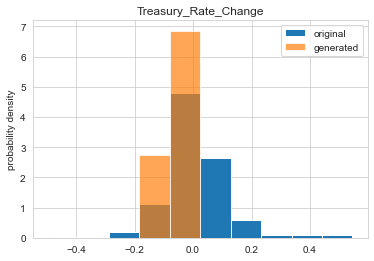

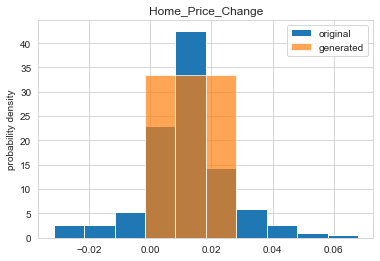

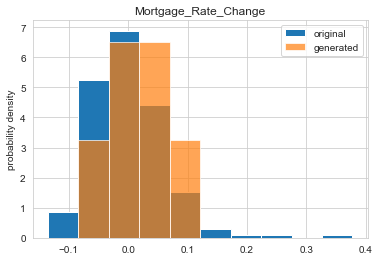

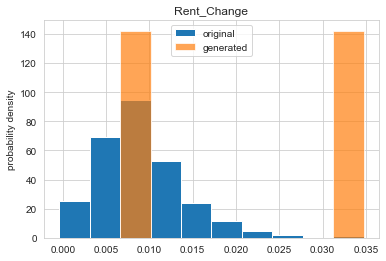

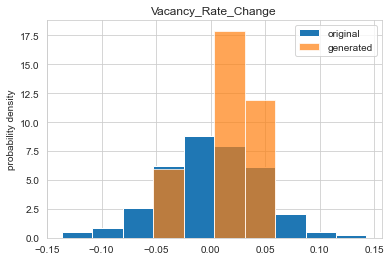

In [ ]:
for idx, col in enumerate(merged_df.drop(columns=col2drop).columns):
    plt.figure()
    plt.title(col)
    #use the same bins for both plots and normalize the density
    _, bins, _= plt.hist(merged_df[col],label='original', density=True)
    plt.hist(gen_data[idx],label='generated', bins=bins, density=True, alpha=0.7)
    plt.ylabel('probability density')
    plt.legend()